In [1]:
#
# Denoising AutoEncoder MNIST
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Get MNIST data set from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist_set = input_data.read_data_sets('images/MNIST/', one_hot = True)

train_img = mnist_set.train.images
train_label = mnist_set.train.labels
test_img = mnist_set.test.images
test_label = mnist_set.test.labels

noise_lev = 0.3
train_img_noised = train_img + noise_lev * np.random.randn(train_img.shape[0], train_img.shape[1])
test_img_noised = test_img + noise_lev * np.random.randn(test_img.shape[0], test_img.shape[1])
print ("Noised data prepared")

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Noised data prepared


In [3]:
# Options for training
learning_rate = 0.001
training_epochs = 50
batch_size = 100
display_step = 10

# Options for Hidden Network Nodes
n_hidden = [256, 128, 256] # hidden layer's node count
w_dev = 0.1

# Options for dropout
drop_out_ratio = 0.7

In [4]:
# Build Graph of Dropout MLP

# Define placeholder & Variables
x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_img.shape[1]])
drop_out_prob = tf.placeholder("float")

def one_layer(_x, _W, _b, _dop):
    return tf.nn.dropout(tf.nn.sigmoid(tf.add(tf.matmul(_x, _W),_b)),_dop)

WS = {}
BS = {}

last_input_layer = x
last_input_layer_size = train_img.shape[1]
for idx, hl_size in enumerate(n_hidden):
    _W = tf.Variable(tf.random_normal([last_input_layer_size, hl_size], stddev=w_dev))
    _b = tf.Variable(tf.random_normal([hl_size])) 
    last_input_layer = one_layer(last_input_layer, _W, _b, drop_out_prob)
    last_input_layer_size = hl_size
    WS['h_' + str(idx)] = _W
    BS['b_' + str(idx)] = _b

WS['out'] = tf.Variable(tf.random_normal([last_input_layer_size, train_img.shape[1]], stddev=w_dev))
BS['out'] = tf.Variable(tf.random_normal([train_img.shape[1]], stddev=w_dev))


# Define operators
out = one_layer(last_input_layer, WS['out'], BS['out'], 1.)
cost = tf.reduce_mean(tf.pow(out- y,2))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


epoch: 000/050  ,  cost: 0.054343


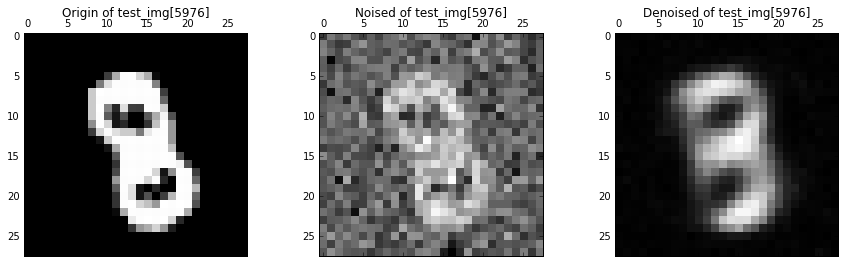

epoch: 010/050  ,  cost: 0.019634


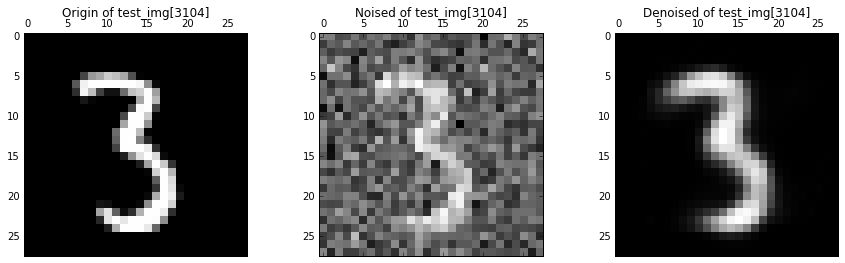

epoch: 020/050  ,  cost: 0.016501


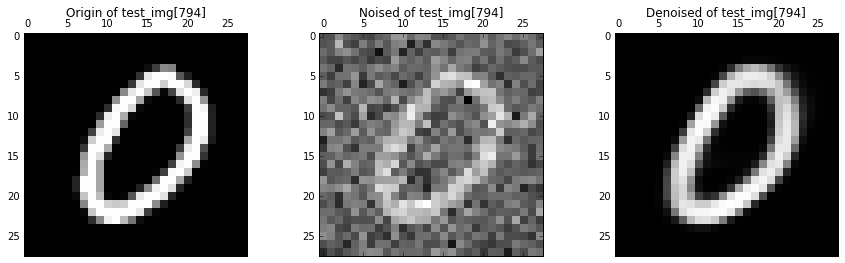

epoch: 030/050  ,  cost: 0.015211


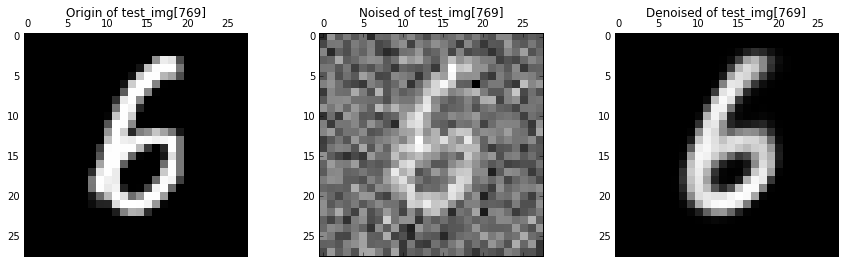

epoch: 040/050  ,  cost: 0.014423


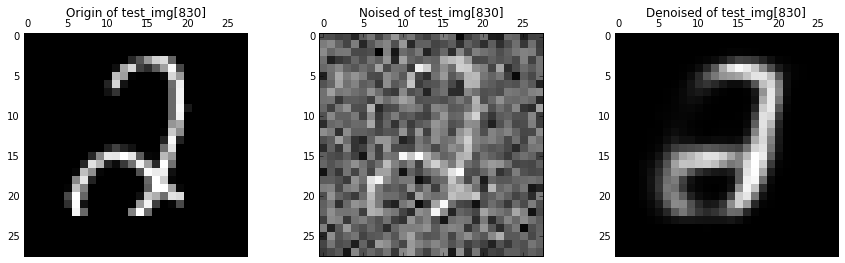

Training complete


In [9]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img_noised[randidx, :]
        batch_ys = train_img[randidx, :] 
        
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        print ("epoch: %03d/%03d  ,  cost: %.6f"% (epoch, training_epochs, avg_cost))
        
        rdx = np.random.randint(test_img.shape[0], size=1)
        original_one = test_img[rdx,:]
        noised_one = test_img_noised[rdx,:]
        out_one = sess.run(out, {x:noised_one, drop_out_prob : 1.})
        
        fig, axs = plt.subplots(1, 3, figsize=(15,4))
        axs[0].matshow(np.reshape(original_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[0].set_title("Origin of test_img" + str(rdx))
        axs[1].matshow(np.reshape(noised_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[1].set_title("Noised of test_img" + str(rdx))
        axs[2].matshow(np.reshape(out_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[2].set_title("Denoised of test_img" + str(rdx))
        plt.show()
        

print ("Training complete")